# 1. Import needed libraries

In [1]:
import sys
print(sys.executable)


/Users/noel_personal/Repos/ML-Projects/Supervised Learning/Brain Tumor/.venv/bin/python


# 2. Preprocessing

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

# 2. Preprocessing

## 2.1 Load data

In [3]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [4]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [5]:
tr_df = train_df('data/Training')

In [6]:
tr_df

,Class Path,Class
0,data/Training/pituitary/Tr-pi_0505.jpg,pituitary
1,data/Training/pituitary/Tr-pi_0263.jpg,pituitary
2,data/Training/pituitary/Tr-pi_0277.jpg,pituitary
3,data/Training/pituitary/Tr-pi_1169.jpg,pituitary
4,data/Training/pituitary/Tr-pi_0511.jpg,pituitary
...,...,...
5707,data/Training/meningioma/Tr-me_1053.jpg,meningioma
5708,data/Training/meningioma/Tr-me_0403.jpg,meningioma
5709,data/Training/meningioma/Tr-me_0365.jpg,meningioma
5710,data/Training/meningioma/Tr-me_0371.jpg,meningioma


In [7]:
ts_df = test_df('data/Testing')

In [8]:
ts_df

,Class Path,Class
0,data/Testing/pituitary/Te-pi_0233.jpg,pituitary
1,data/Testing/pituitary/Te-pi_0227.jpg,pituitary
2,data/Testing/pituitary/Te-pi_0019.jpg,pituitary
3,data/Testing/pituitary/Te-pi_0031.jpg,pituitary
4,data/Testing/pituitary/Te-pi_0025.jpg,pituitary
...,...,...
1306,data/Testing/meningioma/Te-me_0080.jpg,meningioma
1307,data/Testing/meningioma/Te-me_0094.jpg,meningioma
1308,data/Testing/meningioma/Te-me_0137.jpg,meningioma
1309,data/Testing/meningioma/Te-me_0123.jpg,meningioma


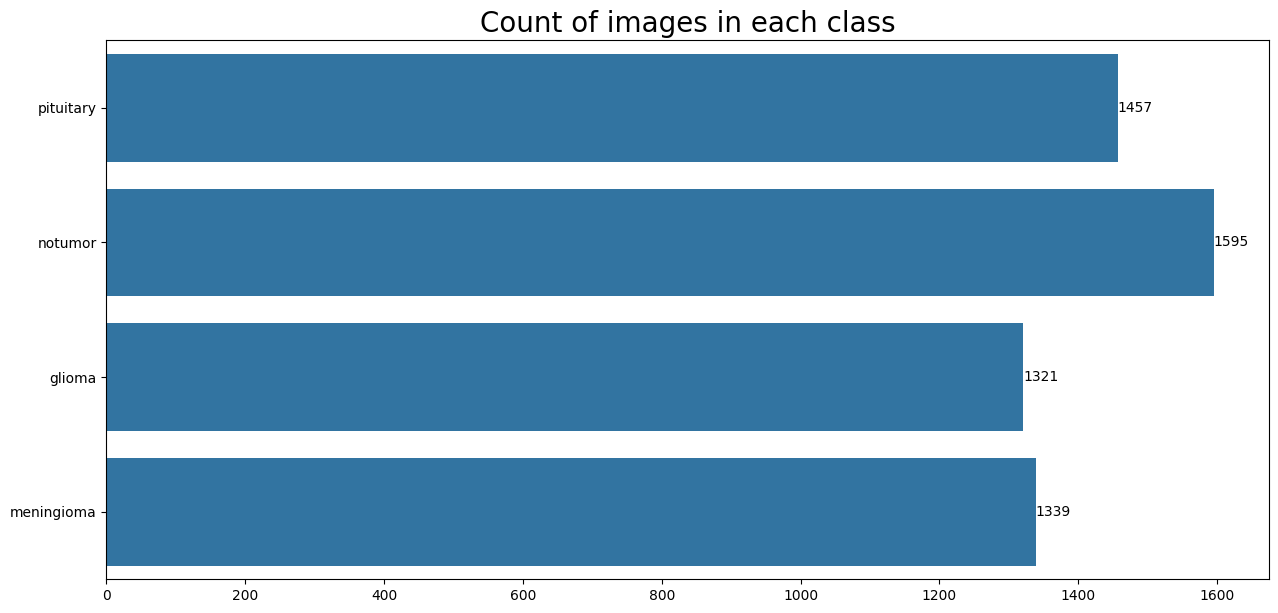

In [9]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

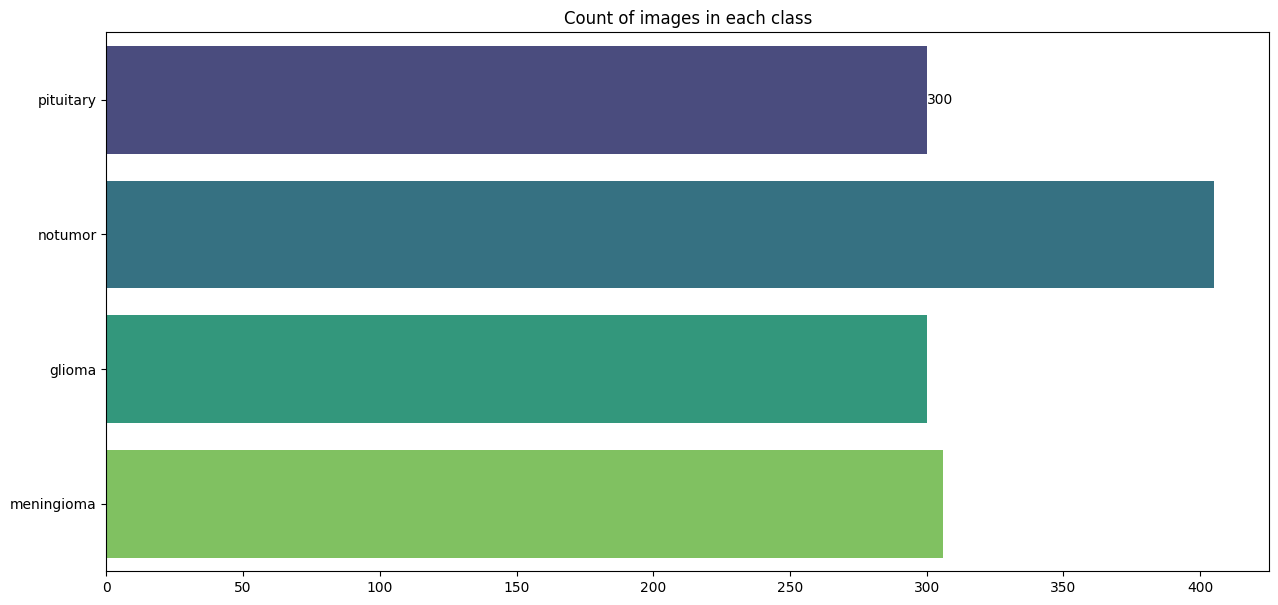

In [10]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

## 2.2 Split data into train, test, valid

In [11]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [12]:
valid_df

,Class Path,Class
991,data/Testing/glioma/Te-gl_0129.jpg,glioma
1023,data/Testing/meningioma/Te-me_0107.jpg,meningioma
61,data/Testing/pituitary/Te-pi_0197.jpg,pituitary
1078,data/Testing/meningioma/Te-me_0274.jpg,meningioma
814,data/Testing/glioma/Te-gl_0219.jpg,glioma
...,...,...
764,data/Testing/glioma/Te-gl_0136.jpg,glioma
554,data/Testing/notumor/Te-no_0206.jpg,notumor
978,data/Testing/glioma/Te-glTr_0004.jpg,glioma
1199,data/Testing/meningioma/Te-me_0182.jpg,meningioma


## 2.3 Data preprocessing

In [13]:
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## 2.4 Getting samples from data

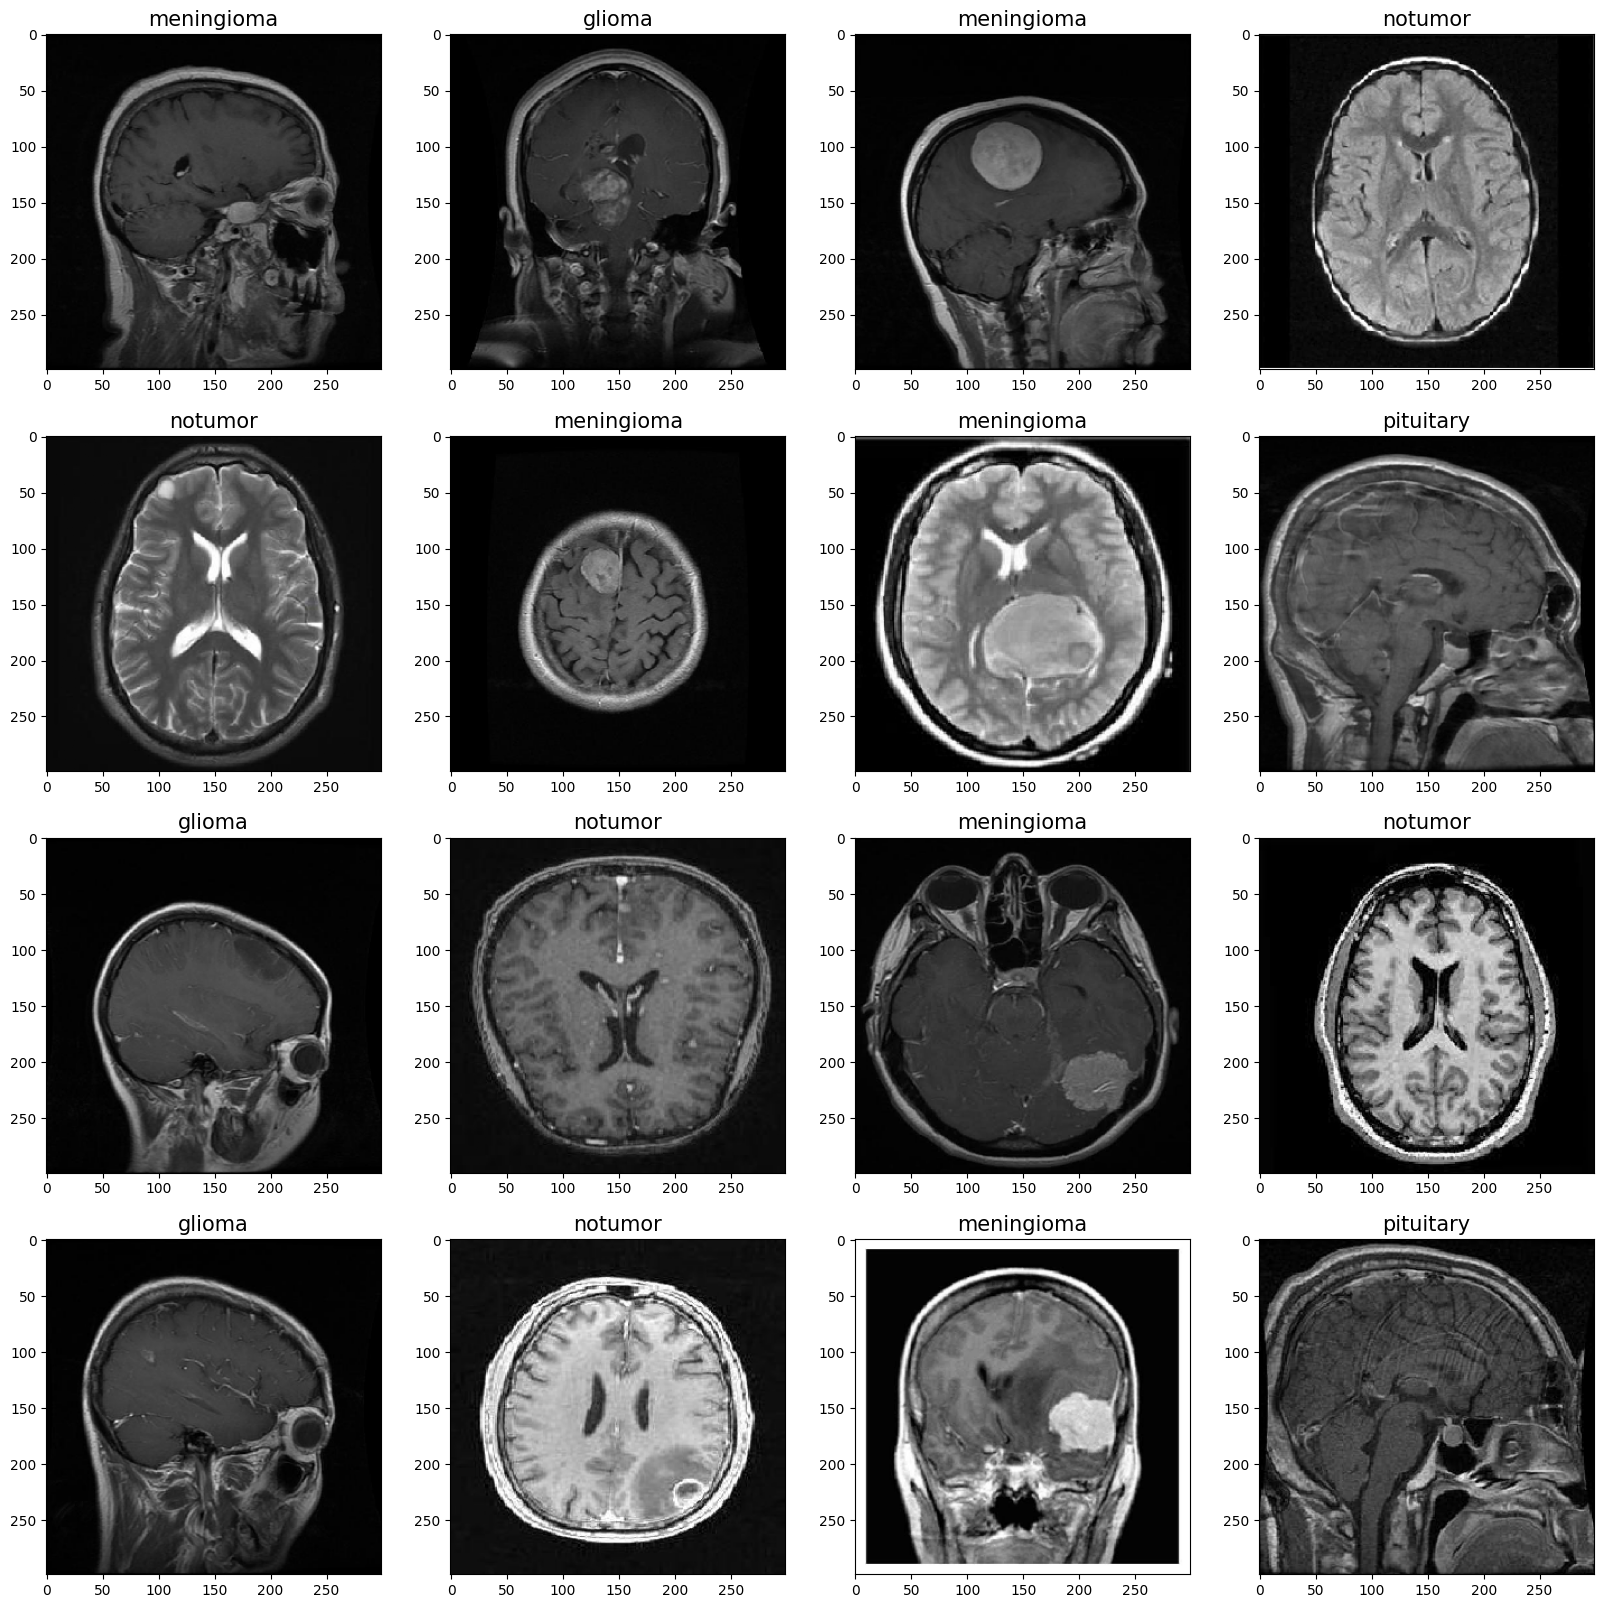

In [14]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

# 3. Building Deep Learning Model

In [ ]:
img_shape=(299,299,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False
    
# data augmentation
from tensorflow.keras import layers, Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21124268 (80.58 MB)
Trainable params: 2106

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# 4. Training

In [17]:
hist = model.fit(tr_gen,
                 epochs=10,
                 validation_data=valid_gen,
                 shuffle= False)

Epoch 1/10
 87/179 [=============>................] - ETA: 22:42 - loss: 0.5562 - accuracy: 0.8107 - precision: 0.8765 - recall: 0.7313

KeyboardInterrupt: 

In [ ]:
hist.history.keys()

## 4.1 Visualize model performance

In [ ]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

# 5. Testing and Evaluation

## 5.1 Evaluate

In [ ]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


In [ ]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

In [ ]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

## 5.2 Testing

In [ ]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((299, 299))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma/Te-meTr_0000.jpg')

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/glioma/Te-glTr_0007.jpg')

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/notumor/Te-noTr_0001.jpg')

In [ ]:
predict('/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0001.jpg')

## Data Augmentation then Retraining
The OP didnt augment the data before training, by useing the tf.keras.layers data aug we can maybe achieve slightly better results! 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

# 1) your augmentation block
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

# 2) suppose `train_ds` is a tf.data.Dataset yielding (image, label_index)
#    and `class_counts` is a dict mapping each label index → its count.

# find the target size (the size of the biggest class)
target_size = max(class_counts.values())

# helper: given a class‐index `c`, return a ds filtered to only that class
def filter_class(ds, c):
    return ds.filter(lambda img, lbl: tf.equal(lbl, c))

augmented_parts = []
for c, count in class_counts.items():
    ds_c = filter_class(train_ds, c)
    # how many more we need?
    delta = target_size - count
    if delta <= 0:
        # already big enough: just take the exact count (or you can repeat to infinite)
        augmented_parts.append(ds_c)
    else:
        # 2a) repeat & augment this class‐only ds
        ds_extra = (
            ds_c
            .repeat()                                    # infinite supply
            .map(lambda img, lbl: (                       # augment ON THE FLY
                 data_augmentation(img, training=True),
                 lbl
            ), num_parallel_calls=tf.data.AUTOTUNE)
            .take(delta)                                 # just take what we need
        )
        # 2b) combine original + extra
        augmented_parts.append(ds_c.concatenate(ds_extra))

# 3) glue all classes back together, shuffle & batch
balanced_ds = augmented_parts[0]
for part in augmented_parts[1:]:
    balanced_ds = balanced_ds.concatenate(part)

balanced_ds = (
    balanced_ds
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


NameError: name 'class_counts' is not defined